In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
df_original = pd.read_csv('/Users/aakash/Downloads/AAPL-2.csv')
df_original.index = df_original.Date
df_original.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2022-10-03,2022-10-03,138.210007,143.070007,137.690002,142.449997,141.609909,114311700
2022-10-04,2022-10-04,145.029999,146.220001,144.259995,146.100006,145.238388,87830100
2022-10-05,2022-10-05,144.070007,147.380005,143.009995,146.399994,145.536606,79471000
2022-10-06,2022-10-06,145.809998,147.539993,145.220001,145.429993,144.572342,68402200
2022-10-07,2022-10-07,142.539993,143.100006,139.449997,140.089996,139.263824,85925600


In [3]:
df = df_original[:4000]
df = df[['Adj Close']]
df.head()

,Adj Close
Date,
2022-10-03,141.609909
2022-10-04,145.238388
2022-10-05,145.536606
2022-10-06,144.572342
2022-10-07,139.263824


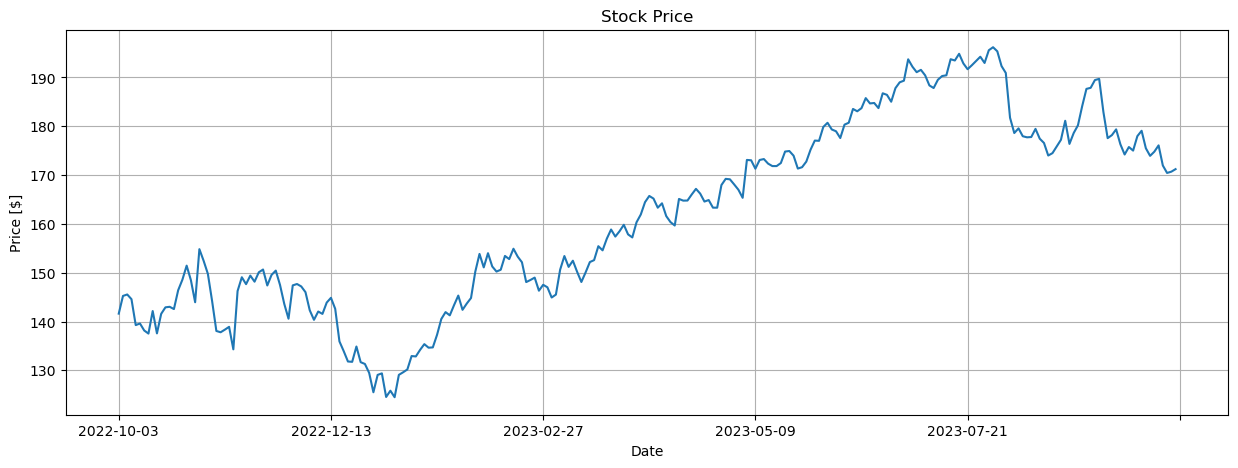

In [4]:
plt.figure(figsize=(15,5))
df['Adj Close'].plot(grid=True)
plt.ylabel('Price [$]')
plt.title('Stock Price');

In [5]:
df['delta'] = np.append(np.array([0]),
np.diff(df['Adj Close'].values))
df['delta'].head()

Date
2022-10-03    0.000000
2022-10-04    3.628479
2022-10-05    0.298218
2022-10-06   -0.964264
2022-10-07   -5.308518
Name: delta, dtype: float64

In [6]:
sp = np.fft.fft(df['delta'].values)
sp[:10]

array([ 29.600098   +0.j        , -49.83228558 +2.98734847j,
         2.68466638 -7.88910961j,  36.85180024-17.97426726j,
         4.98395754-19.90340776j, -54.81935551 +3.9517913j ,
       -10.0127229 +27.45373143j,  15.1144266 -44.89688118j,
        -9.38062306-36.32890513j,  26.79180145-28.93188347j])

In [7]:
df['theta'] = np.arctan(sp.imag/sp.real)
numValues = len(df)
numValuesHalf = numValues / 2
df['amplitude'] = np.sqrt(sp.real**2 + sp.imag**2)/numValuesHalf
df['freq'] = np.fft.fftfreq(sp.size, d=1)
df.head()

,Adj Close,delta,theta,amplitude,freq
Date,,,,,
2022-10-03,141.609909,0.000000,0.000000,0.236801,0.000
2022-10-04,145.238388,3.628479,-0.059876,0.399374,0.004
2022-10-05,145.536606,0.298218,-1.242789,0.066667,0.008
2022-10-06,144.572342,-0.964264,-0.453795,0.328013,0.012
2022-10-07,139.263824,-5.308518,-1.325434,0.164143,0.016


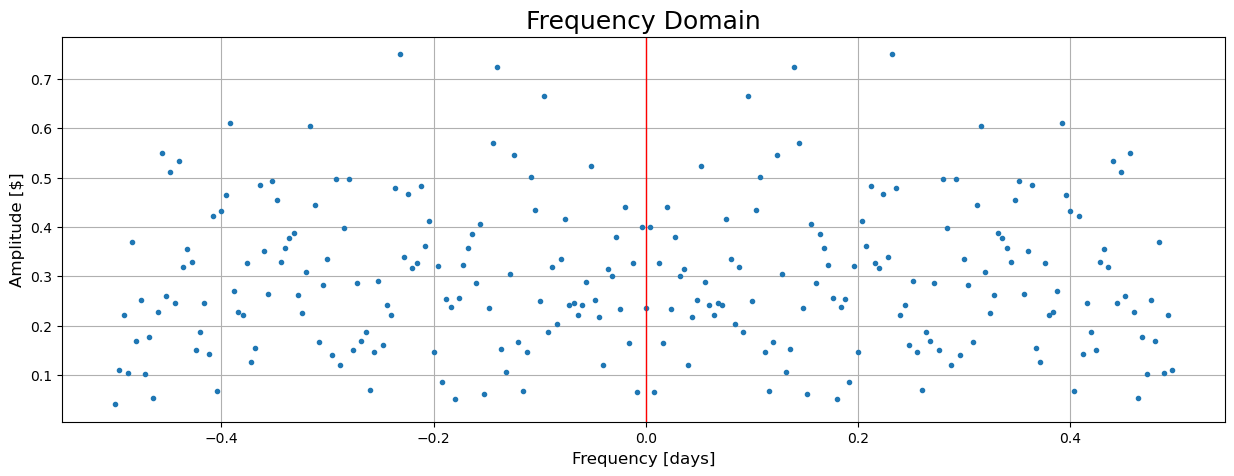

In [8]:
plt.figure(figsize=(15,5))
plt.plot(df['freq'],df['amplitude'].values, '.')
plt.axvline(x=0, ymin=0, ymax = 1, linewidth=1, color='r')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain', fontsize=18)
plt.grid()

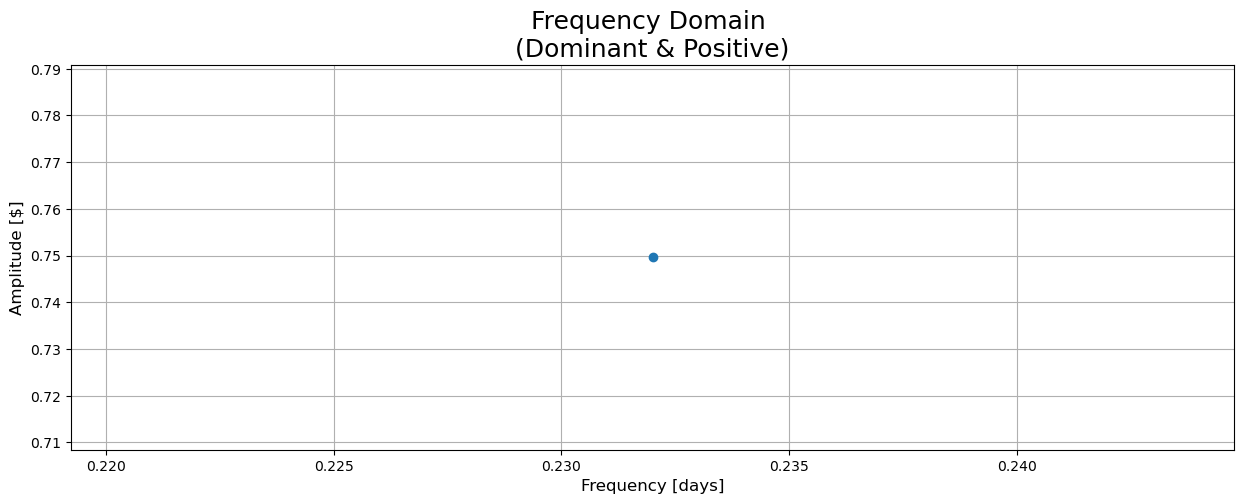

In [9]:
meanAmp = df['amplitude'].mean()
stdAmp = df['amplitude'].std()
dominantAmpCheck = df['amplitude'] > (3*stdAmp + meanAmp) 
positiveFreqCheck = df['freq'] > 0
dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

plt.figure(figsize=(15,5))
plt.plot(dominantFreq, dominantAmp, 'o')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain \n(Dominant & Positive)', fontsize=18)
plt.grid();

In [10]:
regressionDelta = 0

for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift) 
startValue = df['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

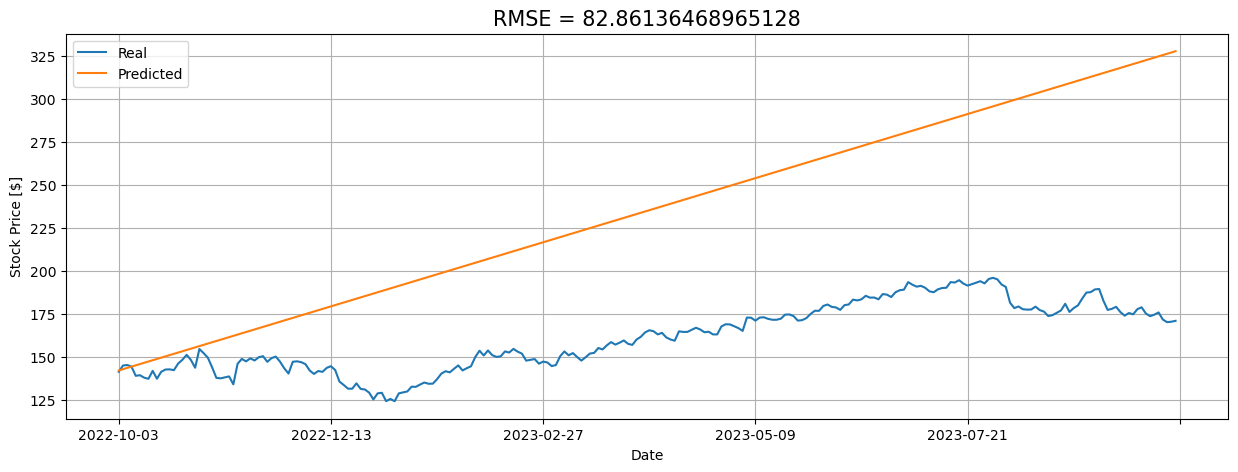

In [11]:
plt.figure(figsize=(15,5))
df['Adj Close'].plot(grid=True)
plt.plot(regression)
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted']);

rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);

In [12]:
def std_filter(std_value):
    
    
    meanAmp = df['amplitude'].mean()
    stdAmp = df['amplitude'].std()
    dominantAmpCheck = df['amplitude'] > (std_value*stdAmp + meanAmp) 
    positiveFreqCheck = df['freq'] > 0
    dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
    dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
    dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']
    
    
    regressionDelta = 0
    for n in range(len(dominantTheta)):
        shift = dominantTheta[n]
        regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift)

    startValue = df['Adj Close'][0]
    regression = startValue - np.cumsum(regressionDelta)
    

    rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))
    
    if np.isnan(rmse):
        rmse = 10000000000000
    
    return rmse

In [13]:
std_values = []
rmse_values = []

for i in np.linspace(0,2,20):
    std_values.append(i)
    rmse_values.append(std_filter(i))

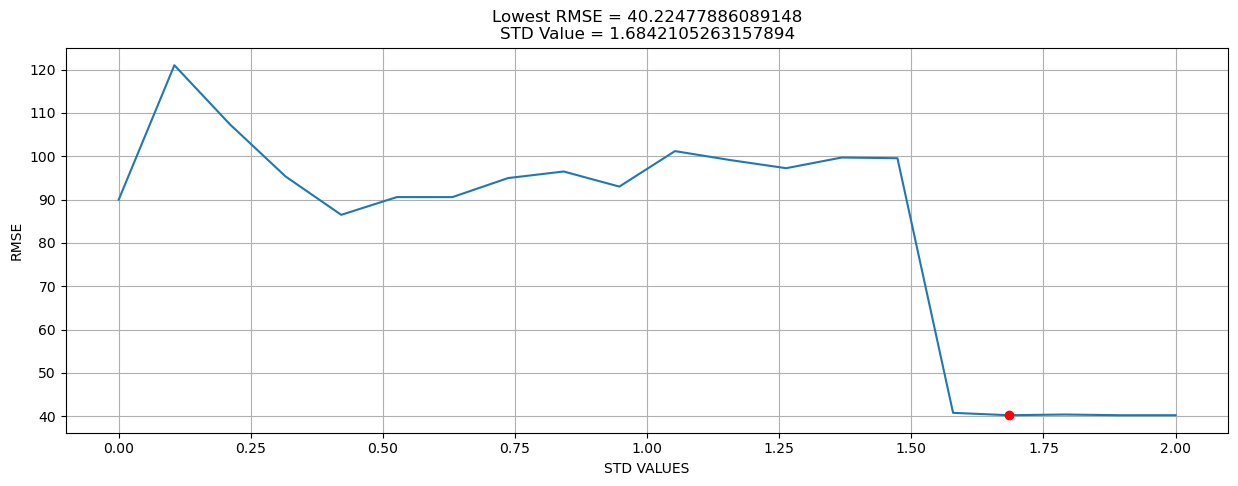

In [14]:
idx = np.array(rmse_values).argmin()
minSTD = std_values[idx]
minRMSE = rmse_values[idx]

plt.figure(figsize=(15,5))
plt.plot(std_values, rmse_values)
plt.plot(minSTD, minRMSE, 'ro')
plt.ylabel('RMSE')
plt.xlabel('STD VALUES')
plt.title('Lowest RMSE = '+str(minRMSE)+'\nSTD Value = '+str(minSTD))
plt.grid()

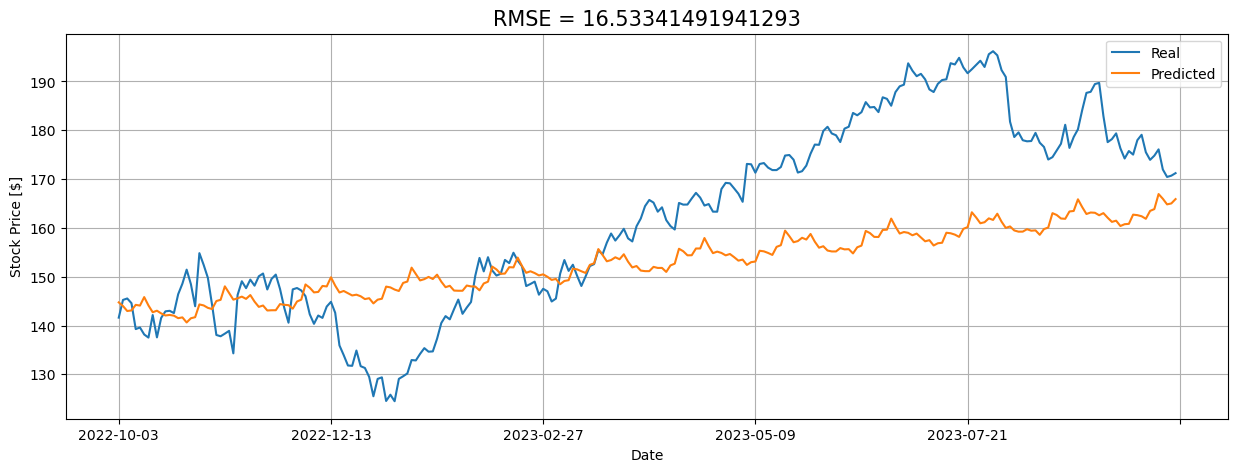

In [15]:
meanAmp = df['amplitude'].mean()
stdAmp = df['amplitude'].std()
dominantAmpCheck = df['amplitude'] > (minSTD*stdAmp + meanAmp) 
positiveFreqCheck = df['freq'] > 0
dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

regressionDelta = 0
for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift)   
startValue = df['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

plt.figure(figsize=(15,5))
df['Adj Close'].plot(grid=True)
plt.plot(regression)
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted']);

rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);
